In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time
import seaborn
import geopandas as gpd
from descartes import PolygonPatch

     |████████████████████████████████| 972kB 5.6MB/s 
     |████████████████████████████████| 14.8MB 283kB/s 
     |████████████████████████████████| 6.5MB 22.1MB/s 


# Merge dataframes

Dataframes contain Landsat data in four bands, as well as NDVI, for the maize growing and harvesting season in South Africa. Data is taken from up to 5 pixels for each field; the ID and GPS coordinates of the field are also given.

In [ ]:
# Combine maize dataframes

filenames = sorted(os.listdir("/content/drive/My Drive/maize"))

maize_data = pd.DataFrame()

for file in filenames:
  chunk = pd.read_csv("/content/drive/My Drive/maize/" + file)
  maize_data = pd.concat([maize_data, chunk])

maize_data.head(10)

,B2,B3,B4,B5,date,field_id,gpslat,gpslon,NDVI
0,782.0,1336.0,1984.0,2615.0,2016-11-12 08:10:49.890,19.0,-33.344802,24.373442,0.137204
1,834.0,1399.0,2138.0,2731.0,2016-11-28 08:10:50.400,19.0,-33.344802,24.373442,0.121791
2,840.0,1392.0,2088.0,2722.0,2016-12-14 08:10:46.770,19.0,-33.344802,24.373442,0.131809
3,845.0,1377.0,2152.0,2654.0,2016-12-30 08:10:44.020,19.0,-33.344802,24.373442,0.104453
4,830.0,1355.0,2059.0,2681.0,2017-01-15 08:10:39.690,19.0,-33.344802,24.373442,0.131224
5,827.0,1379.0,2095.0,2709.0,2017-01-31 08:10:33.140,19.0,-33.344802,24.373442,0.127810
6,737.0,1298.0,1968.0,2612.0,2017-02-16 08:10:26.140,19.0,-33.344802,24.373442,0.140611
7,771.0,1335.0,2006.0,2732.0,2017-03-04 08:10:19.910,19.0,-33.344802,24.373442,0.153229
8,756.0,1271.0,1949.0,2548.0,2017-03-20 08:10:10.050,19.0,-33.344802,24.373442,0.133200
9,656.0,1184.0,1706.0,2252.0,2017-04-05 08:10:02.820,19.0,-33.344802,24.373442,0.137948


In [ ]:
# Combine non-maize dataframes

filenames = sorted(os.listdir("/content/drive/My Drive/nonmaize"))

nonmaize_data = pd.DataFrame()

for file in filenames:
  chunk = pd.read_csv("/content/drive/My Drive/nonmaize/" + file)
  nonmaize_data = pd.concat([nonmaize_data, chunk])

nonmaize_data.head(10)

,B2,B3,B4,B5,date,field_id,gpslat,gpslon,NDVI
0,623.0,1115.0,1390.0,3177.0,2016-11-12 08:10:49.890,0.0,-33.520721,24.679756,0.391285
1,521.0,943.0,1141.0,2790.0,2016-11-28 08:10:50.400,0.0,-33.520721,24.679756,0.419486
2,546.0,971.0,1170.0,2773.0,2016-12-14 08:10:46.770,0.0,-33.520721,24.679756,0.406543
3,542.0,963.0,1143.0,2705.0,2016-12-30 08:10:44.020,0.0,-33.520721,24.679756,0.405925
4,513.0,917.0,1063.0,2784.0,2017-01-15 08:10:39.690,0.0,-33.520721,24.679756,0.447362
5,552.0,969.0,1218.0,2744.0,2017-01-31 08:10:33.140,0.0,-33.520721,24.679756,0.385159
6,564.0,1002.0,1159.0,2903.0,2017-02-16 08:10:26.140,0.0,-33.520721,24.679756,0.429345
7,2302.0,2582.0,2678.0,3356.0,2017-03-04 08:10:19.910,0.0,-33.520721,24.679756,0.112363
8,648.0,1106.0,1294.0,3148.0,2017-03-20 08:10:10.050,0.0,-33.520721,24.679756,0.417380
9,1154.0,1386.0,1519.0,2713.0,2017-04-05 08:10:02.820,0.0,-33.520721,24.679756,0.282136


# Add time (dekad) from harvest as additional variable

The dekad (roughly the first, second and final 10 days of every month) is often used in crop calendars, so is a useful way of comparing growing/harvesting time between countries and climates. The final dekad of the harvesting season (early May) is labelled here as 0, and all other dates are transformed into relative dekads from this one, i.e. counting backwards from 0.

In [ ]:
# Calculate dekad for non-maze

dekad = []

for i, date in maize_data["date"].iteritems():

  # Get date
  d = time.strptime(date, "%Y-%m-%d %H:%M:%S.%f")

  # Calculate dekad from date
  d1 = (d.tm_mon - 1) * 3
  d2 = (d.tm_mday // 10) + 1
  if d2 > 3: d2 = 3
  d = d1 + d2

  # Calculate dekad from time of maize harvest
  d -= 13
  if d > 0: d-= 30

  # Store resulting dekad
  dekad.append(d)

maize_data["dekad"] = dekad
maize_data.head(10)

,B2,B3,B4,B5,date,field_id,gpslat,gpslon,NDVI,dekad
0,782.0,1336.0,1984.0,2615.0,2016-11-12 08:10:49.890,19.0,-33.344802,24.373442,0.137204,-11
1,834.0,1399.0,2138.0,2731.0,2016-11-28 08:10:50.400,19.0,-33.344802,24.373442,0.121791,-10
2,840.0,1392.0,2088.0,2722.0,2016-12-14 08:10:46.770,19.0,-33.344802,24.373442,0.131809,-8
3,845.0,1377.0,2152.0,2654.0,2016-12-30 08:10:44.020,19.0,-33.344802,24.373442,0.104453,-7
4,830.0,1355.0,2059.0,2681.0,2017-01-15 08:10:39.690,19.0,-33.344802,24.373442,0.131224,-11
5,827.0,1379.0,2095.0,2709.0,2017-01-31 08:10:33.140,19.0,-33.344802,24.373442,0.127810,-10
6,737.0,1298.0,1968.0,2612.0,2017-02-16 08:10:26.140,19.0,-33.344802,24.373442,0.140611,-8
7,771.0,1335.0,2006.0,2732.0,2017-03-04 08:10:19.910,19.0,-33.344802,24.373442,0.153229,-6
8,756.0,1271.0,1949.0,2548.0,2017-03-20 08:10:10.050,19.0,-33.344802,24.373442,0.133200,-4
9,656.0,1184.0,1706.0,2252.0,2017-04-05 08:10:02.820,19.0,-33.344802,24.373442,0.137948,-3


In [ ]:
# Calculate dekad for non-maze

dekad = []

for i, date in nonmaize_data["date"].iteritems():

  # Get date
  d = time.strptime(date, "%Y-%m-%d %H:%M:%S.%f")

  # Calculate dekad from date
  d1 = (d.tm_mon - 1) * 3
  d2 = (d.tm_mday // 10) + 1
  if d2 > 3: d2 = 3
  d = d1 + d2

  # Calculate dekad from time of maize harvest
  d -= 13
  if d > 0: d-= 30

  # Store resulting dekad
  dekad.append(d)

nonmaize_data["dekad"] = dekad
nonmaize_data.head(10)

,B2,B3,B4,B5,date,field_id,gpslat,gpslon,NDVI,dekad
0,623.0,1115.0,1390.0,3177.0,2016-11-12 08:10:49.890,0.0,-33.520721,24.679756,0.391285,-11
1,521.0,943.0,1141.0,2790.0,2016-11-28 08:10:50.400,0.0,-33.520721,24.679756,0.419486,-10
2,546.0,971.0,1170.0,2773.0,2016-12-14 08:10:46.770,0.0,-33.520721,24.679756,0.406543,-8
3,542.0,963.0,1143.0,2705.0,2016-12-30 08:10:44.020,0.0,-33.520721,24.679756,0.405925,-7
4,513.0,917.0,1063.0,2784.0,2017-01-15 08:10:39.690,0.0,-33.520721,24.679756,0.447362,-11
5,552.0,969.0,1218.0,2744.0,2017-01-31 08:10:33.140,0.0,-33.520721,24.679756,0.385159,-10
6,564.0,1002.0,1159.0,2903.0,2017-02-16 08:10:26.140,0.0,-33.520721,24.679756,0.429345,-8
7,2302.0,2582.0,2678.0,3356.0,2017-03-04 08:10:19.910,0.0,-33.520721,24.679756,0.112363,-6
8,648.0,1106.0,1294.0,3148.0,2017-03-20 08:10:10.050,0.0,-33.520721,24.679756,0.417380,-4
9,1154.0,1386.0,1519.0,2713.0,2017-04-05 08:10:02.820,0.0,-33.520721,24.679756,0.282136,-3


# Visualise bands over time

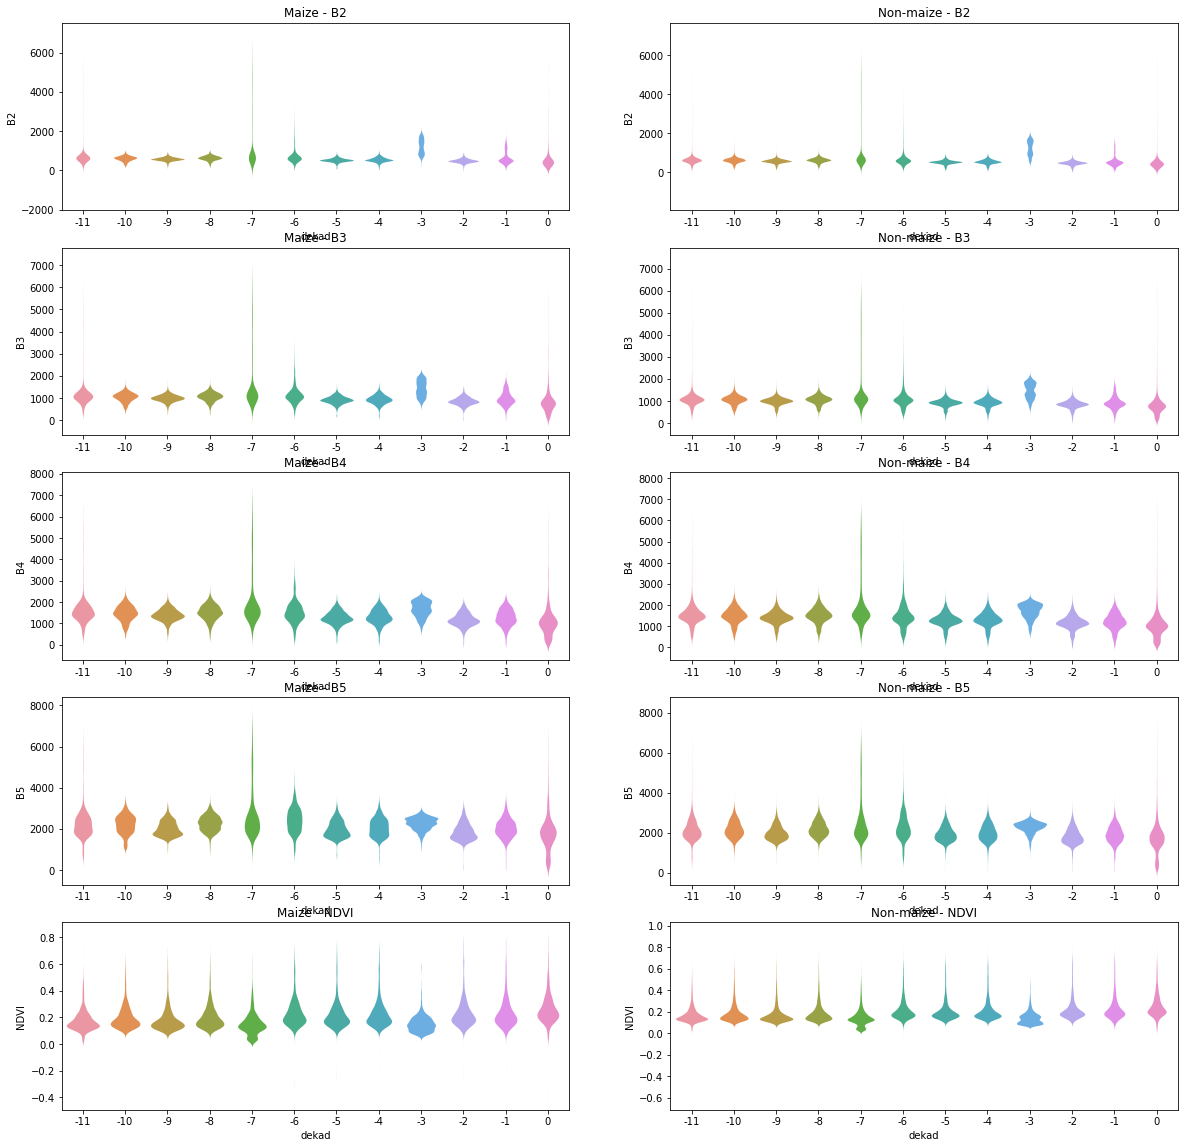

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

for i, band in enumerate(["B2", "B3", "B4", "B5", "NDVI"]):
  
  seaborn.violinplot(x=maize_data["dekad"], y=maize_data[band], linewidth=0, ax=ax[i][0])
  ax[i][0].title.set_text("Maize - " + band);

  seaborn.violinplot(x=nonmaize_data["dekad"], y=nonmaize_data[band], linewidth=0, ax=ax[i][1])
  ax[i][1].title.set_text("Non-maize - " + band);


# Split into training, testing and validation sets

Split data into roughly 60/20/20 ratio, with equal samples of maize and non-maize points.

Ensure that each field appears in only one of these sets.

For our purposes, it is not an advantage to assign fields randomly to these sets, because ultimately the model will be used for a different country with different characteristics anyway, so training and testing on data with the same parameter distributions is not a benefit. So the fields will be divided according to their latitude, such that the top 20% of fields will be assigned as test data, the bottom 20% of fields validation data, and the middle 60% training data.

Keeping each set together geographically will also allow us to perform some spatial aggregation of the data later on.

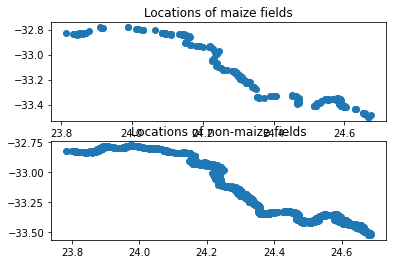

In [ ]:
# Plot median GPS coordinates for each field

fig, ax = plt.subplots(2, 1)

maize_median_coords = maize_data.groupby("field_id", as_index=False).median()[["field_id", "gpslon", "gpslat"]]
ax[0].scatter(maize_median_coords["gpslon"], maize_median_coords["gpslat"])
ax[0].title.set_text("Locations of maize fields")

nonmaize_median_coords = nonmaize_data.groupby("field_id", as_index=False).median()[["field_id", "gpslon", "gpslat"]]
ax[1].scatter(nonmaize_median_coords["gpslon"], nonmaize_median_coords["gpslat"])
ax[1].title.set_text("Locations of non-maize fields")

In [ ]:
# Split by latitude & longitude

def splitByLatLong(df):

  # Find most southeasterly field
  southeast = df[["field_id", "gpslat", "gpslon"]][df["gpslat"] == df["gpslat"].min()]
  
  # Find Euclidean distance of all fields from southeasterly field
  distance = np.sqrt((df["gpslat"] - southeast["gpslat"].item()) ** 2 + ((df["gpslon"] - southeast["gpslon"].item()) ** 2))

  # Separate shortest 20% and longest 20% of distances
  test_thresh = distance.quantile(0.2)
  test_fields = df["field_id"].loc[distance < test_thresh]

  val_thresh = distance.quantile(0.8)
  val_fields = df["field_id"].loc[distance > val_thresh]

  train_fields = df["field_id"].loc[(distance >= test_thresh) & (distance <= val_thresh)]

  return train_fields, test_fields, val_fields

maize_train_fields, maize_test_fields, maize_val_fields = splitByLatLong(maize_median_coords)
nonmaize_train_fields, nonmaize_test_fields, nonmaize_val_fields = splitByLatLong(nonmaize_median_coords)

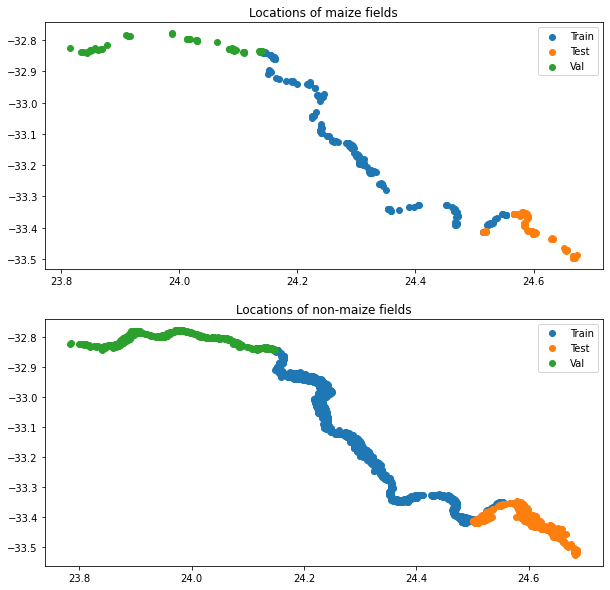

In [ ]:
# Plot median GPS coordinates for each field

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(maize_median_coords["gpslon"].loc[maize_median_coords["field_id"].isin(maize_train_fields)], maize_median_coords["gpslat"].loc[maize_median_coords["field_id"].isin(maize_train_fields)], label="Train")
ax[0].scatter(maize_median_coords["gpslon"].loc[maize_median_coords["field_id"].isin(maize_test_fields)], maize_median_coords["gpslat"].loc[maize_median_coords["field_id"].isin(maize_test_fields)], label="Test")
ax[0].scatter(maize_median_coords["gpslon"].loc[maize_median_coords["field_id"].isin(maize_val_fields)], maize_median_coords["gpslat"].loc[maize_median_coords["field_id"].isin(maize_val_fields)], label="Val")
ax[0].title.set_text("Locations of maize fields")
ax[0].legend()

ax[1].scatter(nonmaize_median_coords["gpslon"].loc[nonmaize_median_coords["field_id"].isin(nonmaize_train_fields)], nonmaize_median_coords["gpslat"].loc[nonmaize_median_coords["field_id"].isin(nonmaize_train_fields)], label="Train")
ax[1].scatter(nonmaize_median_coords["gpslon"].loc[nonmaize_median_coords["field_id"].isin(nonmaize_test_fields)], nonmaize_median_coords["gpslat"].loc[nonmaize_median_coords["field_id"].isin(nonmaize_test_fields)], label="Test")
ax[1].scatter(nonmaize_median_coords["gpslon"].loc[nonmaize_median_coords["field_id"].isin(nonmaize_val_fields)], nonmaize_median_coords["gpslat"].loc[nonmaize_median_coords["field_id"].isin(nonmaize_val_fields)], label="Val")
ax[1].title.set_text("Locations of non-maize fields")
ax[1].legend();

# Random forest classifer

Basic classifer to obtain a baseline

In [79]:
# Function for rearranging dataframe to have one pair of coordinates per row to train on (probably not the most efficient implementation!)

def longToWide(data, maize):

  # Create column names: one per band-dekad combination
  bands = ["B2", "B3", "B4", "B5", "NDVI"]
  cols = []
  for d in np.sort(data["dekad"].unique()):
    for b in bands:
      cols.append(str(d)+"_"+b)

  # Create new dataframe to put data into
  new_df = pd.DataFrame(columns=cols)

  # Extract data for each GPS point
  for i, group in data.groupby(["gpslat", "gpslon"]):

    # Create dictionary in which to store band values for all dekads for this GPS point
    obs = {"gpslat": group.gpslat.items(), "gpslon": group.gpslon.items(), "maize": maize}

    # Extract data for each dekad in this GPS point
    for i, dek in group.groupby("dekad"):

      # Get band values for this dekad and add to dictionary
      d = str(int(dek.dekad.mean()))
      for b in bands:
        obs[d+"_"+b] = dek[b].mean()

    # Append to new dataframe
    new_df = new_df.append(obs, ignore_index=True)

  return new_df


# Transform data into one row per GPS coordinate for training, testing and validation

training_data = pd.concat([longToWide(maize_data.loc[maize_data["field_id"].isin(maize_train_fields)], 1), \
           longToWide(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_train_fields)], 0)])

test_data = pd.concat([longToWide(maize_data.loc[maize_data["field_id"].isin(maize_test_fields)], 1), \
           longToWide(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_test_fields)], 0)])

val_data = pd.concat([longToWide(maize_data.loc[maize_data["field_id"].isin(maize_val_fields)], 1), \
           longToWide(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_val_fields)], 0)])

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Impute missing values
imp = KNNImputer(n_neighbors=20)
imputed_training = imp.fit_transform(training_data.iloc[:, :-3])
imputed_test = imp.fit_transform(test_data.iloc[:, :-3])

# Train random forest
clf = RandomForestClassifier()
clf.fit(imputed_training, training_data.iloc[:, -1])
predictions = clf.predict(imputed_test)

# Check result
print("Precision: ", precision_score(test_data.iloc[:, -1], predictions))
print("Recall: ", recall_score(test_data.iloc[:, -1], predictions))
print("Weighted f1: ", f1_score(test_data.iloc[:, -1], predictions, average="weighted"))
print("Feature importances:", clf.feature_importances_)

Precision:  0.2830188679245283
Recall:  0.1079136690647482
Weighted f1:  0.15625
Feature importances: [0.02071473 0.01738639 0.01670511 0.01937194 0.01768774 0.01436083
 0.01401321 0.0141185  0.02192392 0.01460284 0.01452072 0.01271313
 0.01204772 0.01380078 0.01565446 0.01218447 0.01272636 0.01233435
 0.01406123 0.01571814 0.02509532 0.02137052 0.01691154 0.01745558
 0.02027486 0.01644225 0.01509248 0.01598004 0.01745241 0.01600127
 0.01164463 0.01265807 0.01021093 0.0135875  0.01684025 0.01375494
 0.01208919 0.01245786 0.01544641 0.01379604 0.02561685 0.02438354
 0.02118133 0.02688865 0.02084544 0.01348838 0.01287358 0.01335423
 0.01572892 0.0139626  0.02850185 0.02497241 0.0192121  0.01741298
 0.01820399 0.01638946 0.01728704 0.01576499 0.01712165 0.01560135]


# LSTM

In [ ]:
# Function for converting dataframe for each pair of coordinates to PyTorch tensors (takes half an hour, nested for-loops are probably a bad idea)

import torch

def lstmInput(data, maize):

  bands = ["B2", "B3", "B4", "B5", "NDVI"]
  dekads = [str(x) for x in range(-11,1)]
  new_data = torch.Tensor()

  # Group data by GPS coordinate
  for i, group in data.groupby(["gpslat", "gpslon"]):

    # Create empty dataframe
    cols = bands; cols.append("dekad")
    group_df = pd.DataFrame(columns=cols, index=dekads)
    
    # Extract data for each dekad in this GPS point
    for i, dek in group.sort_values("dekad").groupby("dekad"):
      
      # Average over band values for dekads where there is more than one and append to dataframe
      new_row = dek[["B2", "B3", "B4", "B5", "NDVI", "dekad"]].mean() # Include dekad for now, for debugging
      group_df.loc[str(int(new_row.dekad))] = new_row

    # Convert to tensor
    coord_tensor = torch.Tensor([x for x in np.array(group_df.drop("dekad", axis=1))]).unsqueeze(0)

    # Add tensor for this group/coordinate-pair to larger tensor
    new_data = torch.cat((new_data, coord_tensor))

  # Create tensor for target (maize or not maize) with same number of rows
  targets = torch.tensor(np.ones(new_data.shape[0]) * maize)

  return new_data, targets

# Format training, test and validation sets for LSTM
maize = lstmInput(maize_data.loc[maize_data["field_id"].isin(maize_train_fields)], 1)
nonmaize = lstmInput(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_train_fields)], 0)
lstm_training, targets_training = torch.cat((maize[0], nonmaize[0]), 0), torch.cat((maize[1], nonmaize[1]), 0)

maize = lstmInput(maize_data.loc[maize_data["field_id"].isin(maize_test_fields)], 1)
nonmaize = lstmInput(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_test_fields)], 0)
lstm_test, targets_test = torch.cat((maize[0], nonmaize[0]), 0), torch.cat((maize[1], nonmaize[1]), 0)

maize = lstmInput(maize_data.loc[maize_data["field_id"].isin(maize_val_fields)], 1)
nonmaize = lstmInput(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_val_fields)], 0)
lstm_val, targets_val = torch.cat((maize[0], nonmaize[0]), 0), torch.cat((maize[1], nonmaize[1]), 0)

# lstm_test, targets_test = torch.cat((lstmInput(maize_data.loc[maize_data["field_id"].isin(maize_test_fields)], 1),\
#                            lstmInput(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_test_fields)], 0)), 0)
# print("done test")
# lstm_val, targets_val = torch.cat((lstmInput(maize_data.loc[maize_data["field_id"].isin(maize_val_fields)], 1),\
#                            lstmInput(nonmaize_data.loc[nonmaize_data["field_id"].isin(nonmaize_val_fields)], 0)), 0)

print("Size of training data:", (lstm_training.shape))
print("Size of test data:", (lstm_test.shape))
print("Size of validation data:", (lstm_val.shape))

Size of training data: torch.Size([7298, 12, 5])
Size of test data: torch.Size([2411, 12, 5])
Size of validation data: torch.Size([2380, 12, 5])


In [ ]:
# Impute missing values
from sklearn.impute import KNNImputer
imp = KNNImputer(n_neighbors=20)
all_data = torch.cat([lstm_training, lstm_test, lstm_val])
imputed_data = np.empty(all_data.shape)
for band in range(5):
  imputed_data[:, :, band] = imp.fit_transform(all_data[:,:,band])

imputed_training = torch.Tensor(imputed_data[:lstm_training.shape[0], :, :])
imputed_test = torch.Tensor(imputed_data[lstm_training.shape[0] : lstm_training.shape[0] + lstm_test.shape[0], :, :])
imputed_val = torch.Tensor(imputed_data[lstm_training.shape[0] + lstm_test.shape[0] :, :, :])

In [ ]:
# Normalise band values

band_means = imputed_training.mean(1).mean(0)
band_std = imputed_training.std(1).std(0)

norm_training = (imputed_training-band_means)/band_std
norm_test = (imputed_test-band_means)/band_std
norm_val = (imputed_val-band_means)/band_std

In [37]:
# Define model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

class MaizeLSTM(nn.Module):
    def __init__(self, output_size, input_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(MaizeLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

Precision:  0.0
Recall:  0.0
Weighted f1:  0.0


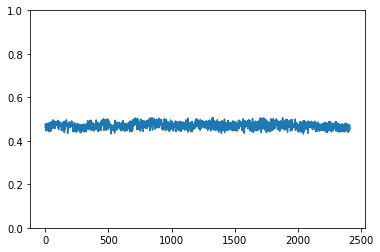

In [97]:
# Check performance of model before training

from sklearn.metrics import precision_score, recall_score, f1_score

torch.manual_seed(1)
device = torch.device("cpu")
with torch.no_grad():
  model = MaizeLSTM(output_size=1, input_dim=5, hidden_dim=5, n_layers=2)
  model.to(device)
  h = model.init_hidden(norm_test.shape[0], device)
  output, _ = model(norm_test, h)

plt.plot(output.numpy())
plt.ylim((0, 1))
print("Precision: ", precision_score(targets_test.numpy(), np.round(output.numpy())))
print("Recall: ", recall_score(targets_test.numpy(), np.round(output.numpy())))
print("Weighted f1: ", f1_score(targets_test.numpy(), np.round(output.numpy()), average="binary"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Average loss: 0.4422094668012588


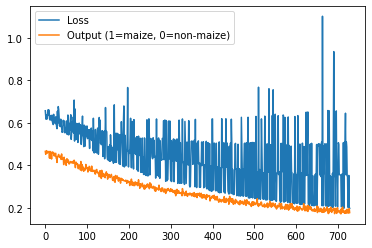

In [92]:
# Train model

torch.manual_seed(1)
model = MaizeLSTM(output_size=1, input_dim=5, hidden_dim=5, n_layers=2)
model.to(device)
lr=0.01
batch_size = 10
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
h = model.init_hidden(batch_size, device)
all_loss = []
all_output = []

# Shuffle training data
shuffle_order = np.random.permutation(norm_training.shape[0])
training_shuffled = norm_training[shuffle_order, :, :]
targets_shuffled = targets_training[shuffle_order]

for iBatch in range(0,training_shuffled.size()[0], batch_size):
  data = training_shuffled[iBatch:iBatch+batch_size, :, :]
  if data.shape[0] < batch_size:
    break
  target = torch.tensor(targets_shuffled[iBatch:iBatch+batch_size])
  data, target = torch.from_numpy(np.array(data)).to(device), torch.from_numpy(np.array(target)).to(device)

  h = tuple([e.data for e in h])
  model.zero_grad()
  output, h = model(data, h)
  target = target.float()
  loss = loss_function(output, target)
  loss.backward()
  # nn.utils.clip_grad_norm_(model.parameters(), 3)
  optimizer.step()
  all_loss.append(np.array(loss.item()))
  all_output.append(np.array(output[0].item()))

plt.plot(all_loss, label="Loss")
print("Average loss:", np.mean(all_loss))
plt.plot(all_output, label="Output (1=maize, 0=non-maize)")
plt.legend();

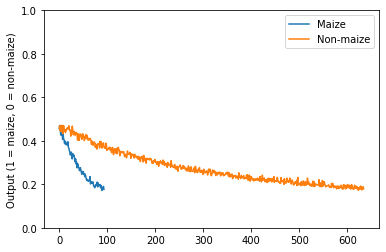

In [90]:
# Plot outputs during training for maize and non-maize points
plt.plot([all_output[x] for x in np.where(targets_shuffled[:len(all_output)]==1)[0]], label="Maize")
plt.plot([all_output[x] for x in np.where(targets_shuffled[:len(all_output)]==0)[0]], label="Non-maize")
plt.legend()
plt.ylim((0, 1))
plt.ylabel('Output (1 = maize, 0 = non-maize)');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Precision:  0.0
Recall:  0.0
Weighted f1:  0.0
Median prediction for maize points: 0.17898136
Median prediction for non-maize points: 0.17972663


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


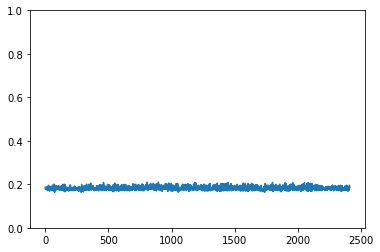

In [96]:
# Test again

torch.manual_seed(1)
predictions = []
with torch.no_grad():
  for iBatch in range(0,norm_test.size()[0], batch_size):

    data = norm_test[iBatch:iBatch+batch_size, :, :]
    if data.shape[0] < batch_size:
      break
    target = torch.tensor(targets_test[iBatch:iBatch+batch_size])
    data, target = torch.from_numpy(np.array(data)).to(device), torch.from_numpy(np.array(target)).to(device)
    output, _ = model(data, h)
    [predictions.append(x) for x in output.numpy()]

plt.plot(predictions)
plt.ylim((0, 1))
print("Precision: ", precision_score(targets_test.numpy()[:len(predictions)], np.round(predictions)))
print("Recall: ", recall_score(targets_test.numpy()[:len(predictions)], np.round(predictions)))
print("Weighted f1: ", f1_score(targets_test.numpy()[:len(predictions)], np.round(predictions), average="binary"))

print("Median prediction for maize points:", np.median([predictions[x] for x in np.where(targets_test.numpy()[:len(predictions)]==1)[0]]))
print("Median prediction for non-maize points:", np.median([predictions[x] for x in np.where(targets_test.numpy()[:len(predictions)]==0)[0]]))